# Lab 11 (Evaluable)

We work at the AI department of a hospital. From the digestive area, they are interested to predict the evolution of the Acute Pancreatitis based on the patient data that has been gathered from different stages.
Besides, the digestive area requires a nice User eXperience (UX) webapp that facilitates the new patient's data introduction, data exploration and prediction.

In summary, you as part of the Data Science team should tackle the challenge including:
- An exhaustive analysis of the data of patients introduced in the platform in the past.
- The development of a predictive model to anticipate the evolution of the patient; in particular, to predict if the patient is going to have persistent failure, i.e. "OF_PERSIS_ANYTIME" variable takes value 1.
- The creation of a streamlit app that allows you to view the results of the analysis and interact with the model.
- Adding an explainability tab to the app so that all doctors can understand each prediction for every patient and a global interpretation of the model

# Practice Information:
**Due date:** By end of November, 26th (23:55h)

**Submission procedure:** via Moodle.

**Name:** Telmo Linacisoro

**NIA:** 253251

In [ ]:
import numpy as np
import pandas as pd
import math

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor

import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#To see all columns of the datasets
pd.set_option('display.max_columns', None)

To facilitate the process of training and evaluation, we have created a function to split and train the original dataset.

**EX[1]** To evaluate the performance of a binary classification model, which is the appropriate visualization to determine the quality of the performance and the threshold value of the decision?

**Solution:** A good visualization for evaluating the performance is the receiver operating characteristic curve, which is helpful to evaluate the trade-off between true positive rate and the false positive rate. In practice it means looking for the point closest to the top-left corner, that is the point with the highest true positive rate and lowest false positive rate.

# 0) Functions

## 0.1) Training function

In [ ]:
def split_and_train(features, stage_df, target, num_var, cat_var, model):
    X = stage_df[features]
    y = stage_df[[target]]


    # Divide the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_processed=X_train

    print("Number of features after coding:", X_train_processed.shape[1] )

    # Train the model
    model.fit(X_train_processed, y_train)


    # Verify if the model has `feature_importances_`
    if hasattr(model, 'feature_importances_'):
        # Obtain the importance of the features
        importances = model.feature_importances_
        # Create a dataframe with the feature_importance
        num_features = X_train.shape[1]
        feature_indices = np.arange(num_features)
        importance_df = pd.DataFrame({'Feature': feature_indices, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)


        # Visualize the importance of the features

        plt.figure(figsize=(10, 12))
        plt.barh(X_train.columns[importance_df['Feature']], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Index of feature')
        plt.title('Importance of the feature')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print("The model does not have the property of 'feature_importances_'")


    return model, X_test, y_test


**[EX2]** Besides, we have created another function to evaluate the model. Please, complete the function to plot the density charts of the probabilities

## 0.2) Model evaluation function

In [ ]:
def evaluation(model, X_test, y_test, target, threshold):

    X_test_processed = X_test
    # Prediction for X_test
    y_test_predict = model.predict(X_test_processed)

    print(confusion_matrix(y_test, y_test_predict))
    print(classification_report(y_test, y_test_predict))

    # Prediction of the probabilities
    y_test_predict_proba = model.predict_proba(X_test_processed)
    y_pred = model.predict(X_test_processed)

    # AUC calculation
    y_test_prob = y_test_predict_proba[:, 1]  # Probabilities for the positive class
    auc = roc_auc_score(y_test, y_test_prob)
    print(f"AUC: {auc:.4f}")

    ## TO DO: Plot of the probabilities distribution
    plt.figure(figsize=(10, 6))

    sns.kdeplot(y_test_prob[y_test.values.ravel() == 0], label="Class 0 (Negative)", fill=True, color="skyblue", alpha=0.6)
    sns.kdeplot(y_test_prob[y_test.values.ravel() == 1], label="Class 1 (Positive)", fill=True, color="orange", alpha=0.6)

    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.title("Probability Density by Class")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    ##

    # Adjust the prediction according to the threshold value
    y_test_total = pd.DataFrame({
        target: y_test.values.ravel(),
        'proba1': y_test_prob
    })
    y_test_total['Predict'] = (y_test_total['proba1'] >= threshold).astype(int)

    print(confusion_matrix(y_test_total[target], y_test_total["Predict"]))
    print(classification_report(y_test_total[target], y_test_total["Predict"]))

    return y_pred


# 1) Data gathering

We upload the dataset from the last dataset

In [ ]:
# Import dataframe
stage2_df = pd.read_csv('Stage_2.csv', sep=";")
stage2_df.head(3)

,ID_PATIENT,BMI,AGE,ALCOHOL_UNITS_WEEK,ALCOHOLCOM,ALCOHOLYEA,YEARABSTIN,ASA,BACTERIALI,COLICBEFOR,HTA,CARDIO,DIABETESAP,DIABETESNE,DYSLIPID,RESP_PREVIOUSDISEA,RENALCRONI,FAMILIARCA,FAMILIAR_A,GENEALTERA,HISTORY_CHOLECYSTECTOMY,HEREDPANCR,NUMBERPREV,PREVIOUS_A,PARASITINF,PCRONICAETIOLOGY,PACKYEAR,CIGARRETEP,SMOKINGYEA,STONESHIST,TRYGLICERI,VIRUSTYPE,ETIOLOGYFI,IPMN_global,OF_PERSIS_ANYTIME,ANTIARRITMICO,ANTIINFLAMATORIO,BETABLOQUEANTES,DIURETICO,IECA,ANTICOAGULANTE,ANTIPLAQUETARIO,ANTIDIABETICO,ESTATINA,BRONCODILATADORES,ANTIDEPRESIVOS,HOURSADMISSPAIN,APCRITER_A,GLASGOWMENTAL,TEMPEAPACHE_ADMISS,PAM_ADMISS,HEARTRATED_ADMISS,RESPFREQUE_ADMISS,SATO2%/FIO2%_ADMISS,SEX
0,1,25.950000,72,0.0,0.0,0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,6,1,13,37.0,60.000000,108,18,3.000000,1
1,2,18.769513,87,0.0,0.0,0,0.0,3,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,48,1,15,36.7,103.666667,64,16,4.619048,0
2,3,25.280000,55,0.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,0.75,20,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,48,1,15,36.0,92.333333,80,16,4.760000,0


# 2) Data wrangling

## 2.1) Feature classification

In [ ]:
#Columns selection
columns_to_remove_stage2=["ID_PATIENT", "OF_PERSIS_ANYTIME"]
stage_2_columns=stage2_df.columns
stage_2_columns=[col for col in stage_2_columns if col not in columns_to_remove_stage2]

# numerical & categorical for stage0:
num_variables_stage2 = stage2_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_variables_stage2 = [var for var in num_variables_stage2 if var not in columns_to_remove_stage2]

categorical_variables_stage2 = stage2_df.select_dtypes(include='object').columns.tolist()
categorical_variables_stage2 = [var for var in categorical_variables_stage2 if var not in columns_to_remove_stage2]


## 2.2) Exploratory data analysis

In [ ]:
num_variables_stage2.append("OF_PERSIS_ANYTIME")

**[EX3]** Calculate the correlation matrix and plot it of the numerical columns. Which are the top 3 variables with more correlation with "OF_PERSIS_ANYTIME" variable?

Top 3 variables most correlated with 'OF_PERSIS_ANYTIME':
SATO2%/FIO2%_ADMISS    0.237365
GLASGOWMENTAL          0.198291
BACTERIALI             0.183964
Name: OF_PERSIS_ANYTIME, dtype: float64


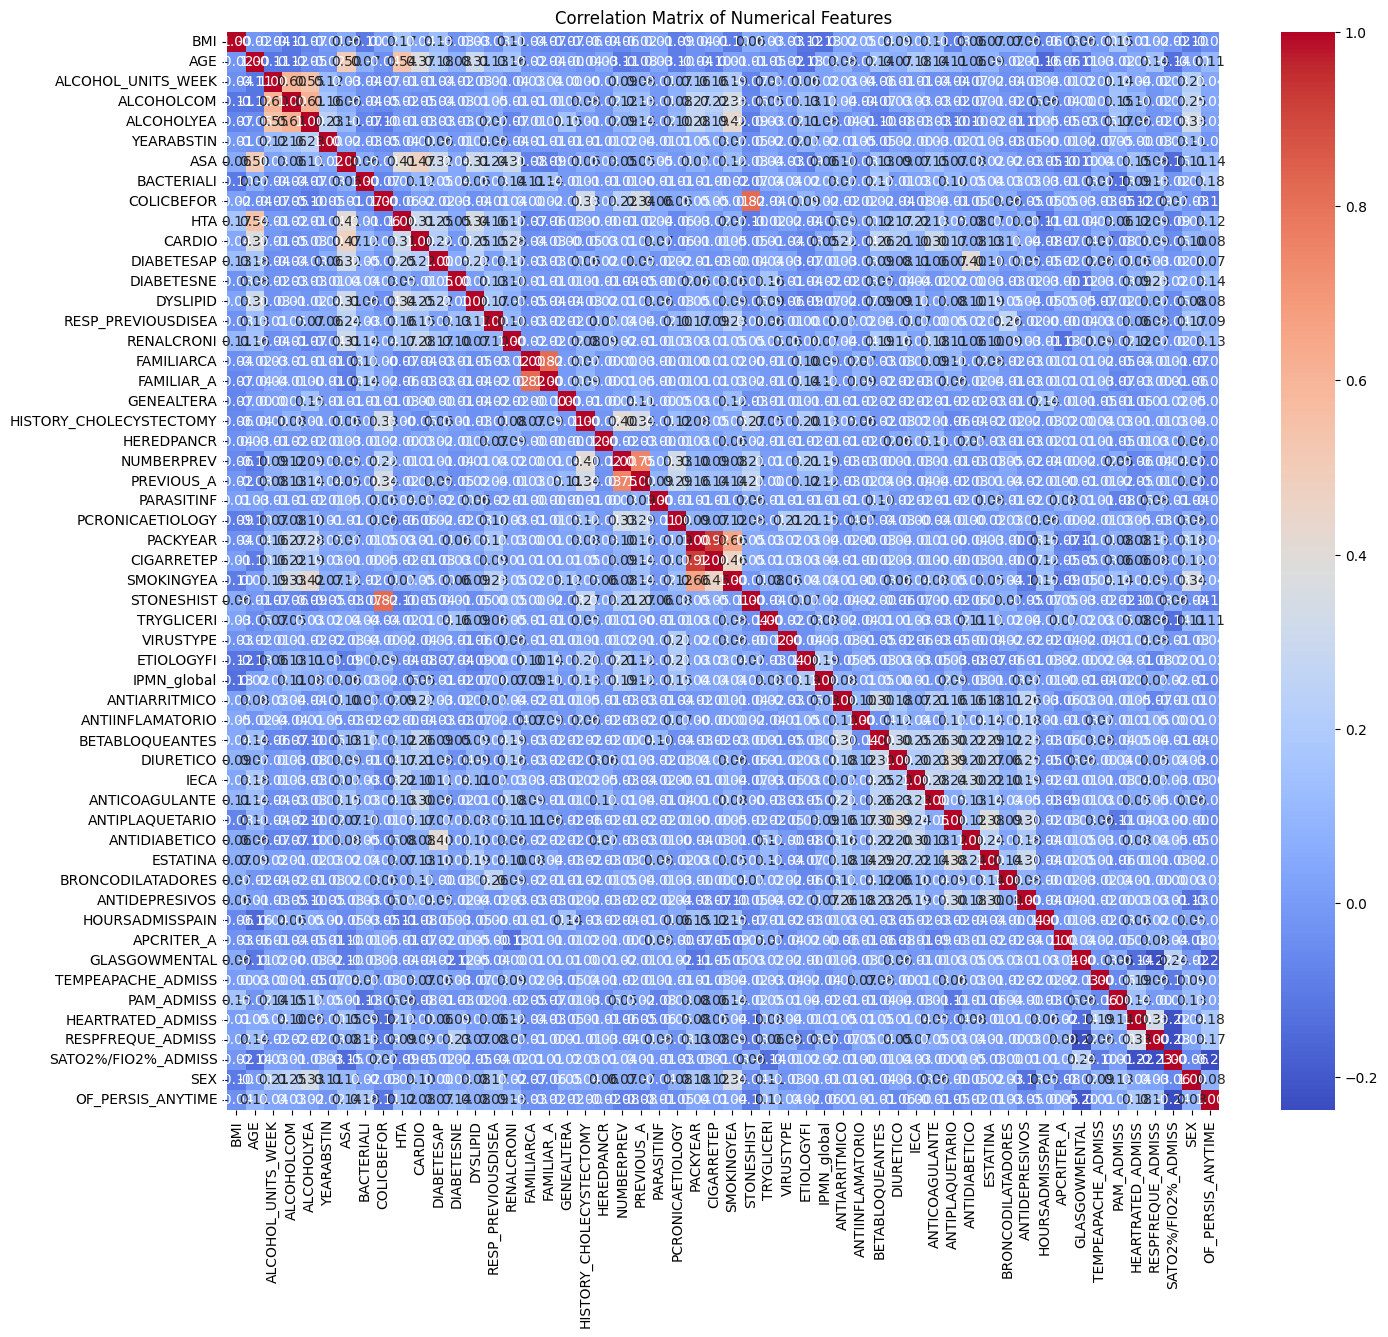

In [ ]:
##Solution
numerical_data = stage2_df[num_variables_stage2]
correlation_matrix = numerical_data.corr()

correlations_with_target = correlation_matrix["OF_PERSIS_ANYTIME"].drop("OF_PERSIS_ANYTIME")
top_3_correlated = correlations_with_target.abs().sort_values(ascending=False).head(3)

print("Top 3 variables most correlated with 'OF_PERSIS_ANYTIME':")
print(top_3_correlated)

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

**Solution** The variables that correlates more with OF_PERSIS_ANYTIME are:
*   SATO2%/FIO2%_ADMISS
*   GLASGOWMENTAL          
*   BACTERIALI             

# 3) Modelling

Let's train our model using the defined functions.

In [ ]:
num_variables_stage2 = [var for var in num_variables_stage2 if var not in columns_to_remove_stage2]

In [ ]:
model_stage2_OFPA=RandomForestClassifier(n_estimators=107, random_state=42, class_weight="balanced", min_samples_leaf=17, max_depth=19)

Number of features after coding: 53


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


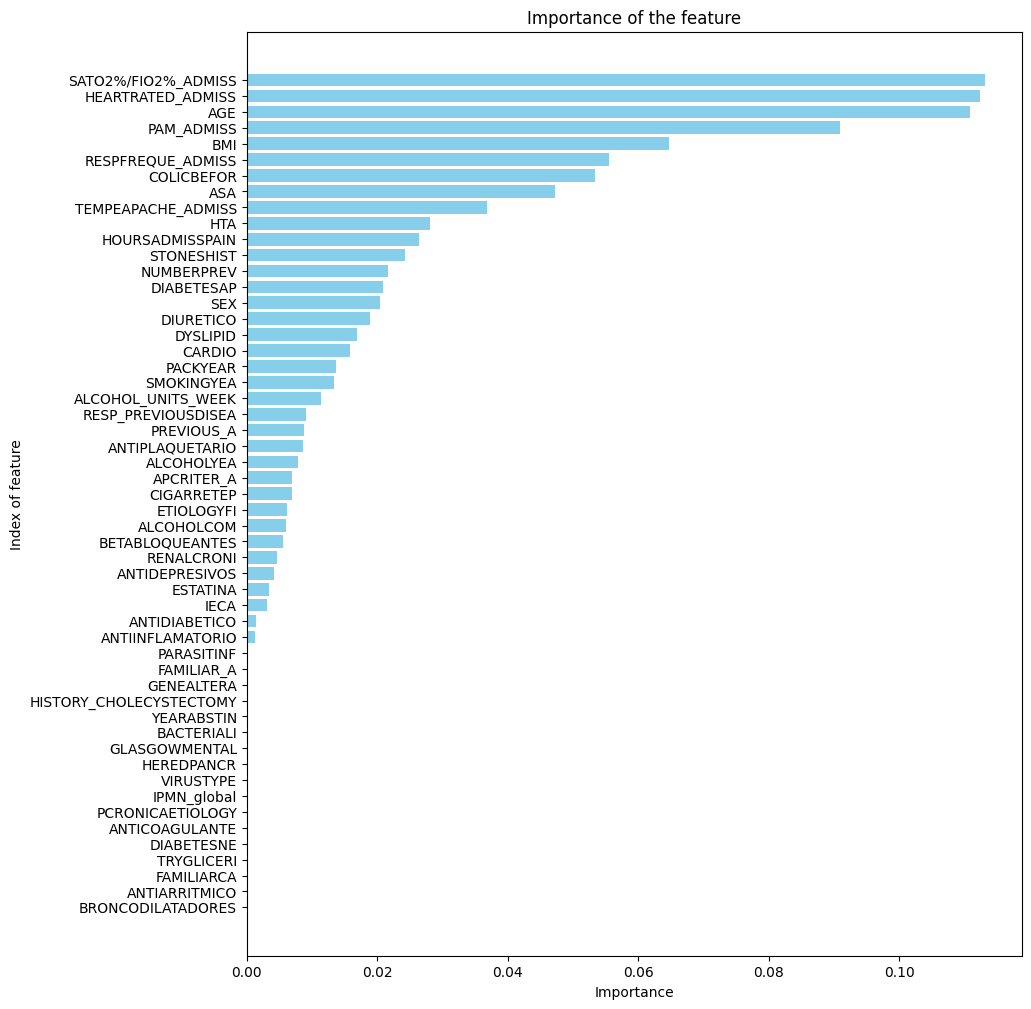

In [ ]:
#Training the model
model_trained_OFPA, X_test, y_test=split_and_train(stage_2_columns, stage2_df, "OF_PERSIS_ANYTIME", num_variables_stage2, categorical_variables_stage2, model_stage2_OFPA)

**EX[4]** Evaluate the model using the defined ***evaluation()*** function. In our use case, should we optimize the recall or the precision? Justify your answer.

[[88 11]
 [13  8]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        99
           1       0.42      0.38      0.40        21

    accuracy                           0.80       120
   macro avg       0.65      0.63      0.64       120
weighted avg       0.79      0.80      0.80       120

AUC: 0.7754


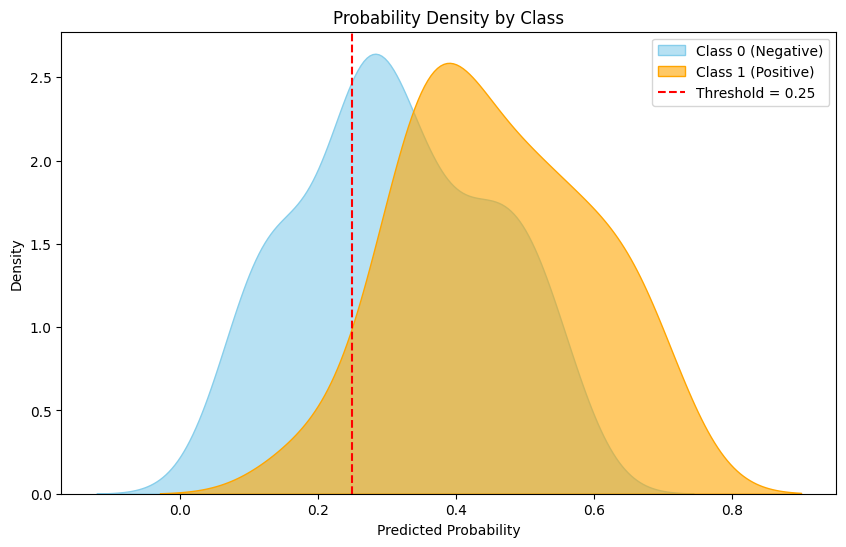

[[29 70]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.97      0.29      0.45        99
           1       0.22      0.95      0.36        21

    accuracy                           0.41       120
   macro avg       0.59      0.62      0.40       120
weighted avg       0.84      0.41      0.43       120



In [ ]:
#Evaluate the model
y_pred = evaluation(model_trained_OFPA, X_test, y_test, "OF_PERSIS_ANYTIME", threshold = 0.25)

**Solution:** We will optimize recall over precision because missing patients who require urgent care could lead to severe consequences, whereas false positives may be less harmful, though they may lead to unnecessary follow-up treatments or tests. Therefore a good threshold value would be 0.20-0.25 where false negatives are minimized without an unmanageable increase in false positives.

# 4) Explainability AI

As an excellent data scientist, we cannot conclude our work without understanding how the model works. In this section of the project, we will apply SHAP as a technique to understand, debug and explain our model.

In [ ]:
X_test["target"]=y_test
X_test["prediction"]=y_pred
X_test=X_test.reset_index(drop=True)

## 4.1) Global explainability

Train a Shap explainer and calculate the shap_values object for the X_test dataset

In [ ]:
import shap
shap.initjs()
explainer=shap.Explainer(model_stage2_OFPA)
shap_values_OFPA = explainer(X_test.iloc[:,:-2])

**[EX5]** Which is the shape of shap_values_OFPA object?

In [ ]:
##Solution
print(shap_values_OFPA.shape)

(120, 53, 2)


Solution: The shape is (120, 53, 2).

To access the SHAP values of the class 1 we should use:

In [ ]:
# Access to the SHAP values for class 1
shap_values_OFPA_class_0 = shap_values_OFPA[:, :, 0]
shap_values_OFPA_class_1 = shap_values_OFPA[:, :, 1]

**[EX6]** Which is the average prediction for all patients?

In [ ]:
#Solution
shap_values_OFPA_class_0_mean = shap_values_OFPA_class_0.base_values.mean()
shap_values_OFPA_class_1_mean = shap_values_OFPA_class_1.base_values.mean()

print("Average prediction for class 0:", shap_values_OFPA_class_0_mean)
print("Average prediction for class 1:", shap_values_OFPA_class_1_mean)

Average prediction for class 0: 0.5059740914048545
Average prediction for class 1: 0.49402590859514545


**[EX7]** Plot the summary plot for global explainability of the model. Which are your insights?

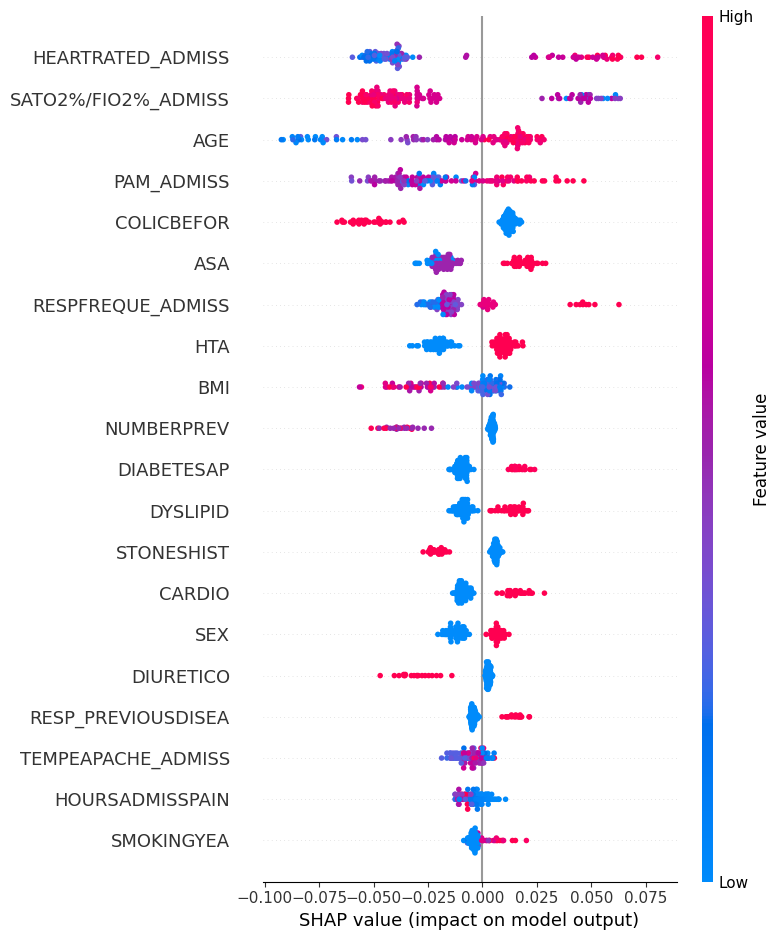

In [ ]:
#Solution
shap.summary_plot(shap_values_OFPA_class_1, X_test.iloc[:, :-2])

**EX[8]** Build the bar plot for the global explainability of the model but just for the top 15 variables. Tip: use the max_display=15 in the corresponding plot

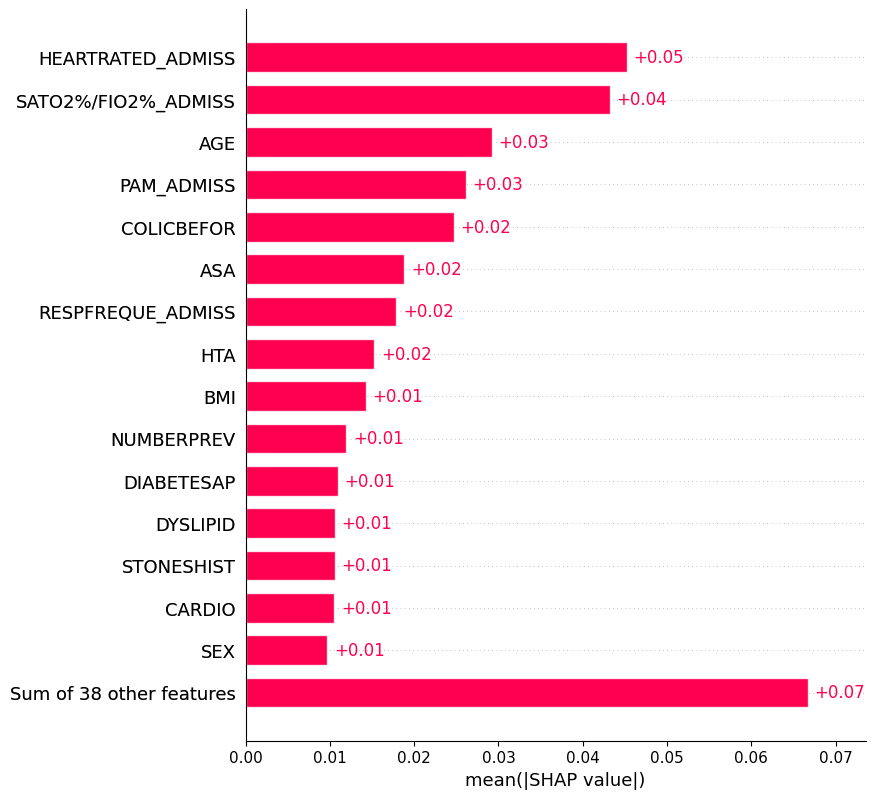

In [ ]:
#Solution
#Plot var: built for class 1 of all top 15 shap_values
num_variables = 15
shap.plots.bar(shap_values_OFPA_class_1, max_display=num_variables+1) # 15 variables + 1 for SHAP value of the sum of other features

**EX[9]** Let's do deep dive in the variables `AGE`, `HEARTRATED_ADMISS` and `SATO2%/FIO2%_ADMISS`. What are the most relevant insights about these evolution of the features' values and their Shap values.

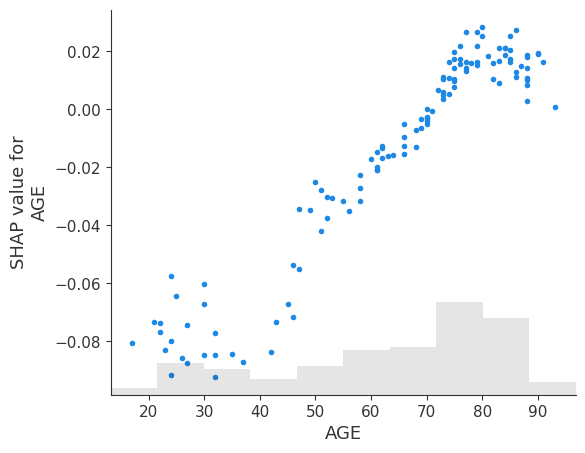

In [ ]:
#Solution
shap.plots.scatter(shap_values_OFPA_class_1[:, X_test.columns.get_loc("AGE")])

We can see that as age increases, the SHAP value also increases, indicating that age becomes a more significant contributor to the model's predictions and is more or less linearly correlated.

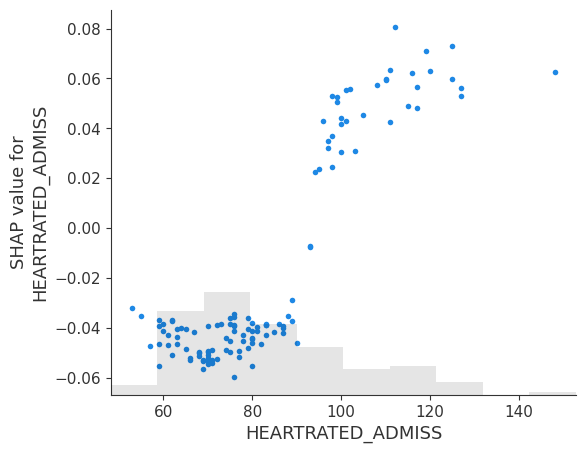

In [ ]:
#Solution
shap.plots.scatter(shap_values_OFPA_class_1[:, X_test.columns.get_loc("HEARTRATED_ADMISS")])

The bulk of the distribution lies between 60 and 90 heart rate, with SHAP values close to 0, meaning it doesn’t affect the prediction much. However, for higher heart rates, we can see that the SHAP value increases, indicating that when the heart rate is high, the prediction becomes higher.

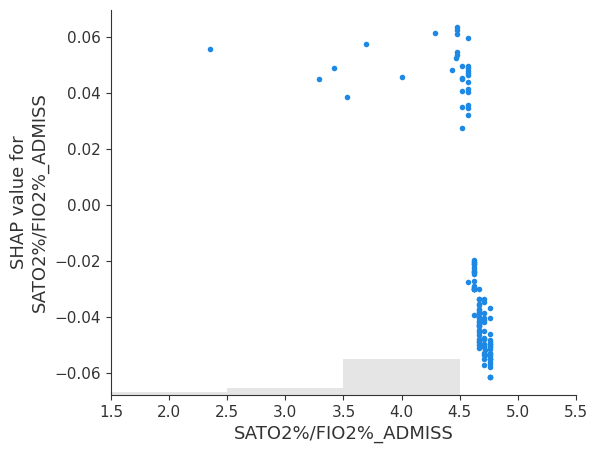

In [ ]:
#Solution
shap.plots.scatter(shap_values_OFPA_class_1[:, X_test.columns.get_loc("SATO2%/FIO2%_ADMISS")])

In general, SHAP values are close to 0. However, low SAT02&FIO2% values show higher SHAP values, meaning that they significantly increase the prediction of persistent organ failure. In contrast, higher SAT02&FIO2% values slightly decrease the prediction, because it represents improved respiratory function.

### Local explainability

Local explainability facilitates the understanding of the prediction for some particular cases. In other words, XAI closes to a personalized prediction explainability. Let's use the first sample of X_test for the following exercises.

**EX[10]** Plot the waterfall and decision plot for two patients: one with prediction of being class 0 (i.e. No OF_PERSIST_ANYTIME) and another with prediction of being class 1 (i.e. OF_PERSIST_ANYTIME)

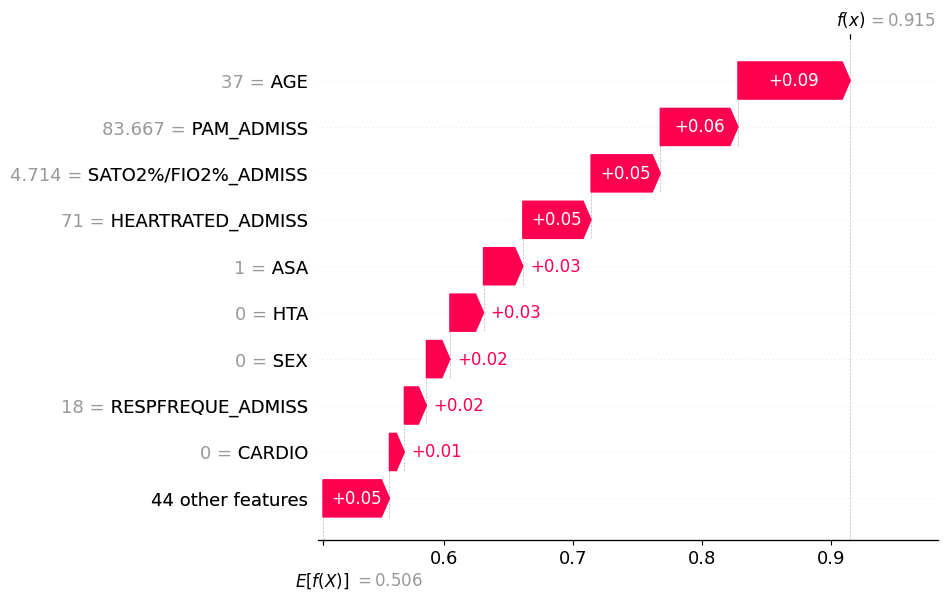

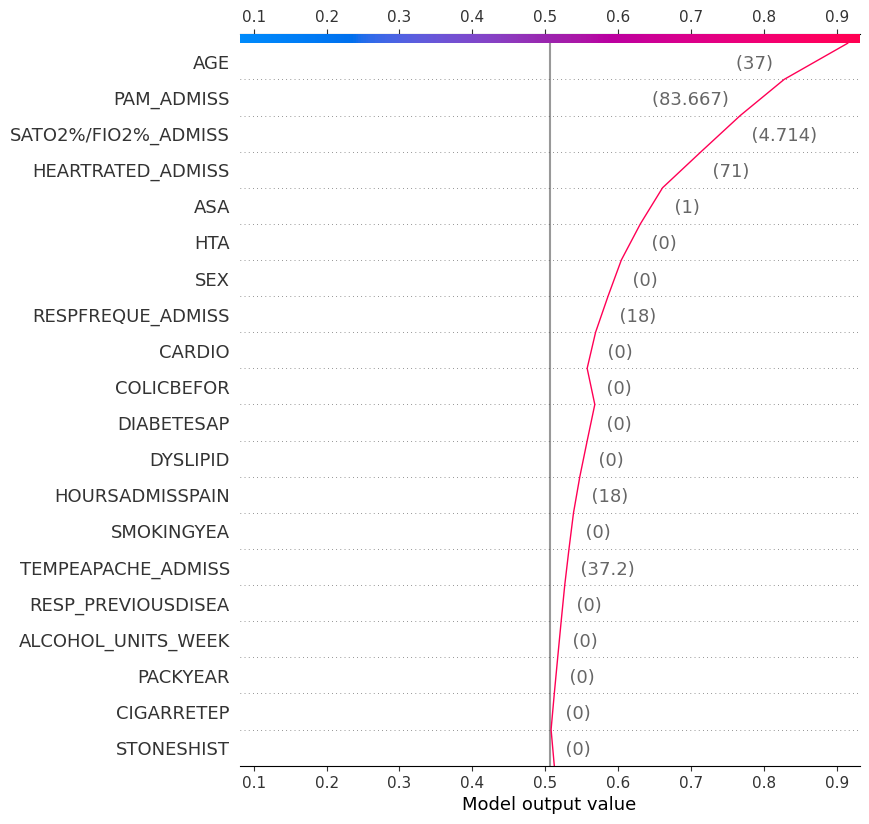

In [45]:
#Solution for a patient with prediction of being class 0
index_class_0 = X_test[X_test['prediction'] == 0].index[0]
shap.plots.waterfall(shap_values_OFPA_class_0[index_class_0])
shap.decision_plot(explainer.expected_value[0],shap_values_OFPA.values[index_class_0,:,0],X_test.iloc[index_class_0,:-2])

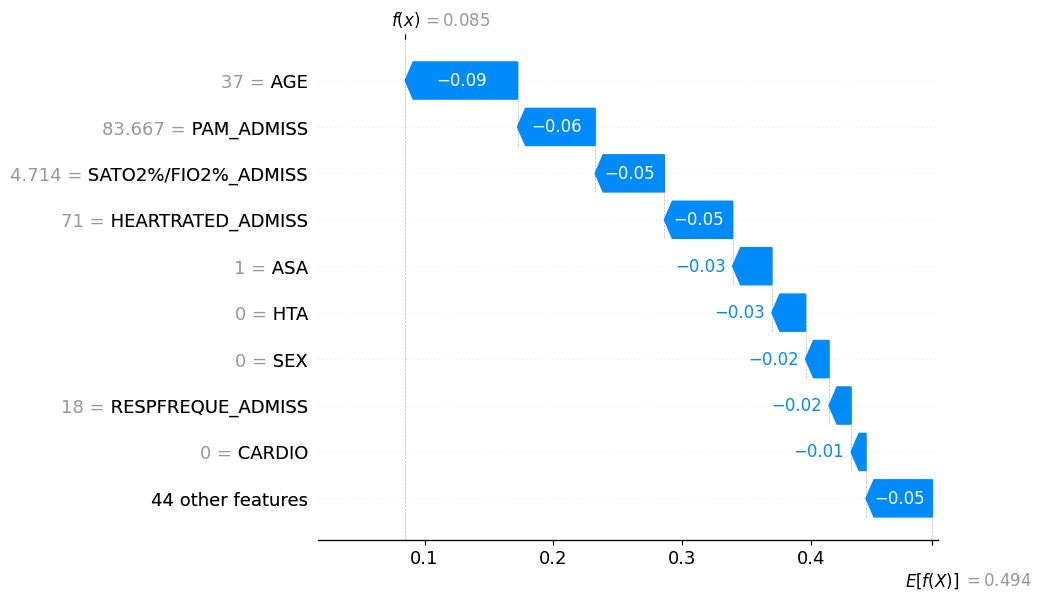

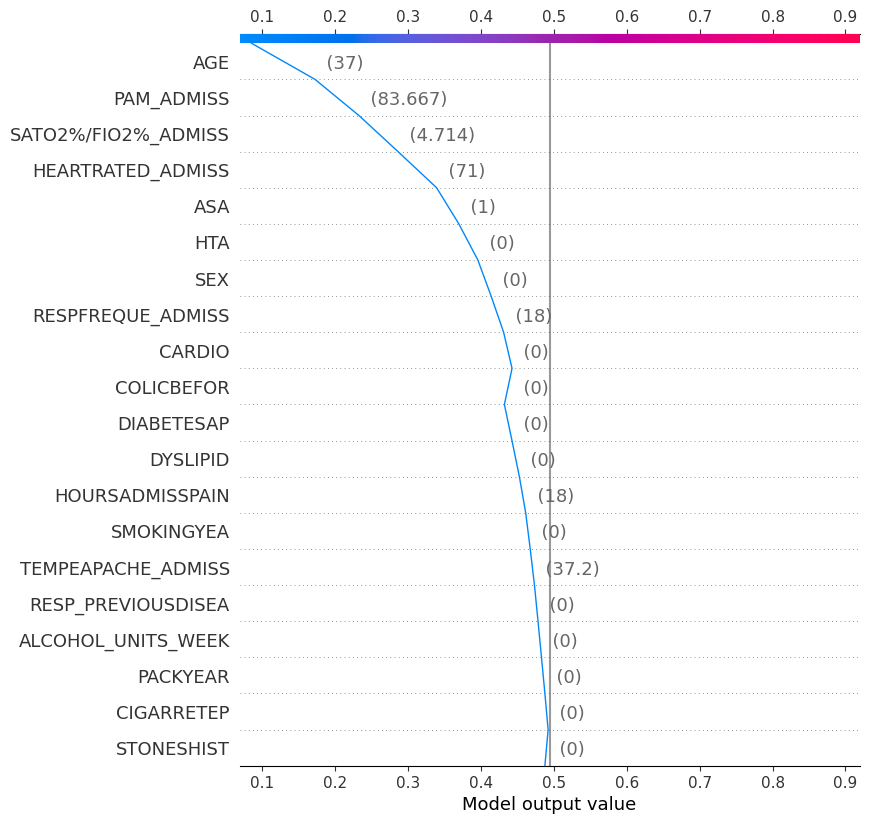

In [44]:
#Solution for a patient with prediction of being class 1
index_class_1 = X_test[X_test['prediction'] == 1].index[0]
shap.plots.waterfall(shap_values_OFPA_class_1[index_class_1])
shap.decision_plot(explainer.expected_value[1],shap_values_OFPA.values[index_class_1, :, 1],X_test.iloc[index_class_1, :-2])

**EX[11]** Which are the factors that increase the risk of OF_PERSIST_ANYTIME?

**Solution:** The factors that increase the risk of OF_PERSIST_ANYTIME include:

*   Age
*   PAM Admiss (Patient Admission Severity Score)
*   SatO2%/Fio2% Admiss (Oxygen Saturation/FiO2 Ratio at Admission)
*   Heart Rate Admiss
*   ASA (American Society of Anesthesiologists Classification)
*   HTA (Hypertension)
*   Sex
*   Respiratory Frequency Admiss
*   Cardio

# 5) Output

As next step you create your own webapp. Store your prediciton model using pickle as follows:

In [46]:
import pickle

# Guardar el modelo en un archivo
filename = 'OF_PERSIS_ANYTIME_classification_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_trained_OFPA, file)

print(f"Your model has been stored as '{filename}'")

Your model has been stored as 'OF_PERSIS_ANYTIME_classification_model.pkl'
